The m-1-m DQNN-based QAE with modified decoder (model3)  and the conjugate layer $V^2=V^{1\dagger}$. m=3, p=0.2 
This code has a batch.

In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np

2023-10-25 15:02:14.628098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
m=3 #number of GHZ's qubits
npar = 3*2*m #number of learning parameters
h = 1
def dqnn(m,params,**kwargs):
    #V1
    j=0
    s=0
    for i in range(m):   
        qml.U3(params[j], params[j+1], params[j+2], wires=2*m+h+i)
        j = j+3
    for i in range(m):
        qml.IsingXX(params[3*m+s],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingYY(params[3*m+s+1],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingZZ(params[3*m+s+2],wires=[3*m+h-1-i,2*m+h-1])
        s = s+3
    
    #################################################
    
    #V1dagger
    j=0
    s=(m-1)*3
    for i in range(m-1):
        qml.adjoint(qml.IsingZZ(params[3*m+s+2], wires=[2*m+h-m+i,2*m+h-1-m+i]))
        qml.adjoint(qml.IsingYY(params[3*m+s+1], wires=[2*m+h-m+i,2*m+h-1-m+i]))
        qml.adjoint(qml.IsingXX(params[3*m+s], wires=[2*m+h-m+i,2*m+h-1-m+i]))
        s = s-3
        
    qml.adjoint(qml.IsingZZ(params[3*m+2], wires=[2*m+h-1,2*m+h-1-m]))
    qml.adjoint(qml.IsingYY(params[3*m+1], wires=[2*m+h-1,2*m+h-1-m]))
    qml.adjoint(qml.IsingXX(params[3*m], wires=[2*m+h-1,2*m+h-1-m]))
    
    for i in range(m):
        qml.adjoint(qml.U3(params[j], params[j+1], params[j+2], wires=m+i)) 
        j = j+3


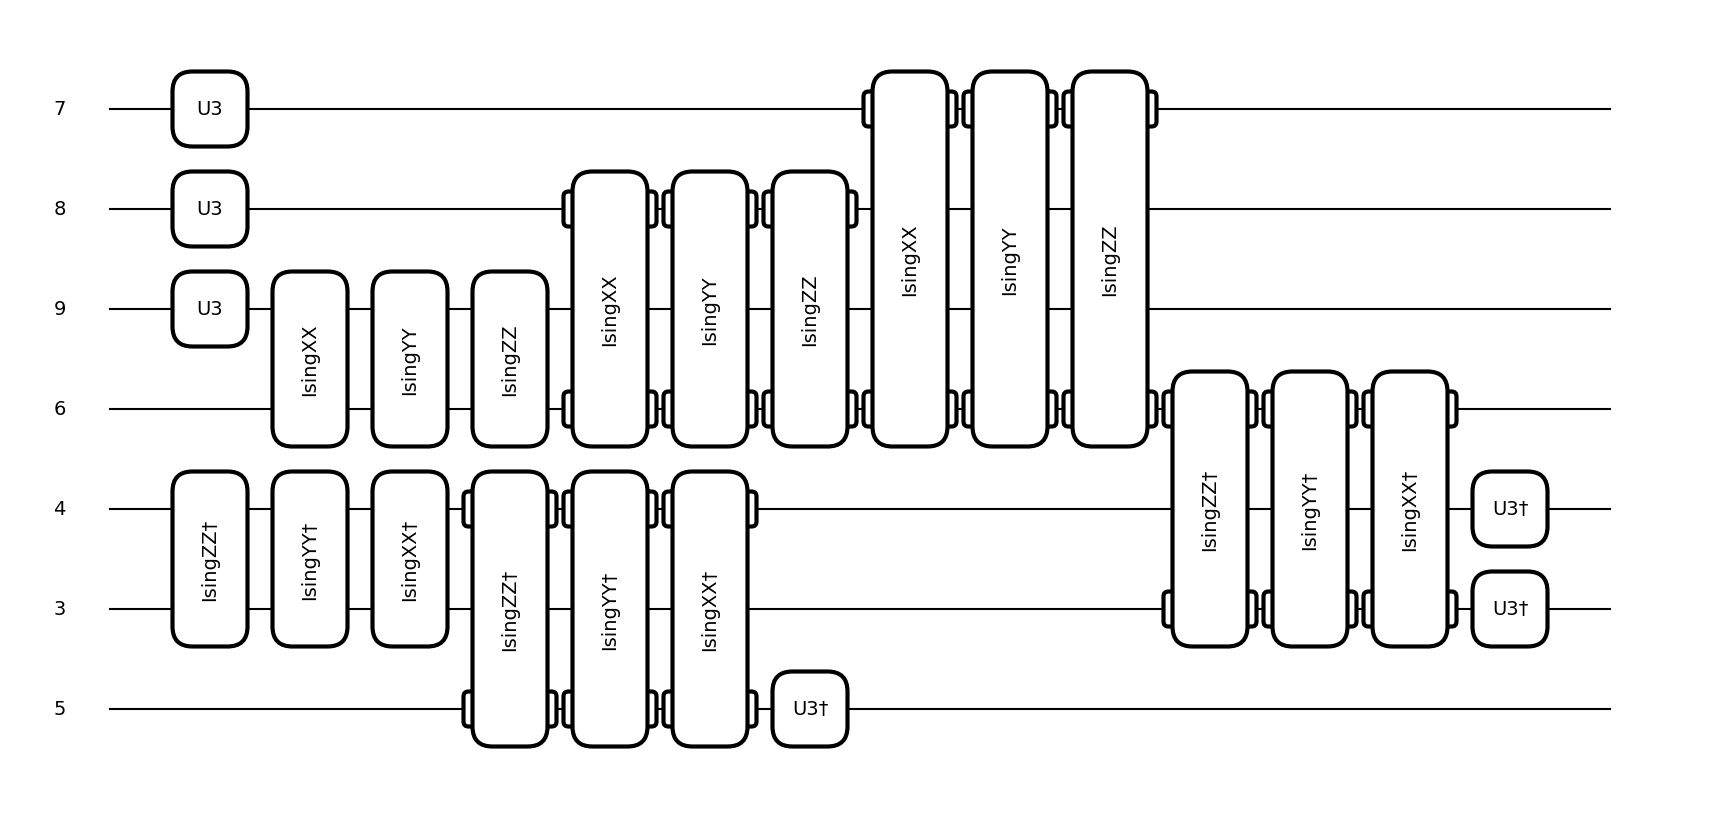

In [3]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
params = np.array([0]*npar)
fig, ax = qml.draw_mpl(dqnn)(m,params)
plt.show()

In [4]:
def dqnn1(m,params,**kwargs):
    #V1
    j=0
    s=0
    for i in range(m):
        qml.U3(params[j], params[j+1], params[j+2], wires=2*m+h+i)
        j = j+3
    for i in range(m):
        qml.IsingXX(params[3*m+s],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingYY(params[3*m+s+1],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingZZ(params[3*m+s+2],wires=[3*m+h-1-i,2*m+h-1])
        s = s+3

In [5]:
wires = 2*m
qubits_a = range(0,m)
qubits_b = range(m,wires)

############################################
def swap_readout_op_penny(qubits_a, qubits_b, m):
    # it is P_0
    """Readout operation for variational swap test.

    Computes the bitwise and of matched qubits from qubits_a and qubits_b.

    Args:
        qubits_a:  The qubits system A act on
        qubits_b: The qubits system B act on
    """

    def _countSetBits(m):
        count = 0
        while m:
            count += m & 1
            m >>= 1
        return count

    def _one_proj(a):
        return (qml.Identity(a)-qml.PauliZ(a))/2

    if len(qubits_a) != len(qubits_b):
        raise ValueError("unequal system sizes.")

    ret_op = qml.Identity(range(0,wires))-qml.Identity(range(0,wires))
    for i in range(1 << len(qubits_a)):
        if _countSetBits(i) % 2 == 0:
            tmp_op = qml.Identity(range(0,wires))
            for j, ch in enumerate(bin(i)[2:].zfill(len(qubits_a))):
                intermediate = _one_proj(qubits_a[j]) @ _one_proj(qubits_b[j])
                if ch == '0':
                    intermediate = qml.Identity(qubits_a[j])@ qml.Identity(qubits_b[j]) - intermediate
                tmp_op = intermediate @ tmp_op
            ret_op = tmp_op + ret_op

    return ret_op

In [6]:
p=0.2
def state_preparation_validation(name, p, m, h): # p = noise probability, 
                                                 # m = number of GHZ qubits, 
                                                 # h = number of hidden layer qubits,
                                                 # 0,...,m are target qubits,
                                                 # qu = the total number of qubits.
    qu = m+m+h+m
        
    if name == 'GHZ_m_target':
        qml.Hadamard(wires=0)
        for k in range(1,m):
            qml.CNOT(wires=[0,k]) 
           
            
    elif name == 'noisy_GHZ_bitflip_m_target':
        prob = np.random.rand(m)
        qml.Hadamard(wires=0)
        for k in range(1,m):
            qml.CNOT(wires=[0,k])
            if prob[k] <= p: # flips each bit with proba p
                qml.PauliX(wires=k)
        if prob[0] <= p:
            qml.PauliX(wires=0)              
    
    elif name == 'GHZ_m':
        qml.Hadamard(wires=qu-m)
        for k in range(qu-m+1,qu):
            qml.CNOT(wires=[qu-m,k]) 
 
    elif name == 'uniform_bitflip_m':
        prob = np.random.rand(m)
        for k in range(qu-m,qu):
            qml.Hadamard(wires=k)
            if prob[k-qu+m] <= p: # flips each bit with proba p
                qml.PauliX(wires=k) 
            

    elif name == 'noisy_GHZ_bitflip_m':
        prob = np.random.rand(m)
        qml.Hadamard(wires=qu-m)
        for k in range(qu-m+1,qu):
            qml.CNOT(wires=[qu-m,k])
            if prob[k-qu+m] <= p: # flips each bit with proba p
                qml.PauliX(wires=k)
        if prob[k-qu+m] <= p:
            qml.PauliX(wires=qu-m)

    elif name == 'noisy_GHZ_QDC':
        probas = [1 - 3*p/4, p/4, p/4, p/4]
        gate_inds = np.random.choice(np.arange(4), size = m, p = probas)
        qml.Hadamard(wires=qu-m)
        for k in range(qu-m+1,qu):
            qml.CNOT(wires=[qu-m,k])
            if gate_inds[k-qu+m] == 1:
                qml.PauliX(wires=k)
            elif gate_inds[k-qu+m] == 2:
                qml.PauliY(wires=k)
            elif gate_inds[k-qu+m] == 3:
                qml.PauliZ(wires=k)
        if gate_inds[k-qu+m-1] == 1:
            qml.PauliX(wires=qu-m)
        elif gate_inds[k-qu+m-1] == 2:
            qml.PauliY(wires=qu-m)
        elif gate_inds[k-qu+m-1] == 3:
            qml.PauliZ(wires=qu-m)
    
    elif name == 'rigged_QDC': # QDC where 1st and 2nd qubits have different probas
        probas_rigged = [1-p, p/2, p/2, 0]
        probas_rigged2 = [1 - 29*p/30, 2*p/5, 2*p/5, p/6]
        probas = [1 - 3*p/4, p/4, p/4, p/4]
        gate_inds = np.random.choice(np.arange(4), size = m - 2, p = probas)
        gate_inds_r = np.random.choice(np.arange(4), p = probas_rigged)
        gate_inds_r2 = np.random.choice(np.arange(4), p = probas_rigged2)
        qml.Hadamard(wires=qu-m)
        qml.CNOT(wires=[qu-m,qu-m+1])
        if gate_inds_r2 == 1:
            qml.PauliX(wires=qu-m+1)
        elif gate_inds_r2 == 2:
            qml.PauliY(wires=qu-m+1)
        elif gate_inds_r2 == 3:
            qml.PauliZ(wires=qu-m+1)
        s=0    
        for k in range(qu-m+2,qu):
            qml.CNOT(wires=[qu-m,k])
            if gate_inds[s] == 1:
                qml.PauliX(wires=k)
            elif gate_inds[s] == 2:
                qml.PauliY(wires=k)
            elif gate_inds[s] == 3:
                qml.PauliZ(wires=k)
            s=s+1    
        if gate_inds_r == 1:
            qml.PauliX(wires=qu-m)
        elif gate_inds_r == 2:
            qml.PauliY(wires=qu-m)
        elif gate_inds_r == 3:
            qml.PauliZ(wires=qu-m)

In [7]:
def swap_anc_free(m):  #,t):
    i = 0
    for k in range(m):
        qml.Hadamard(wires=k)
        qml.CZ(wires=[k+m, k])
        #qml.RZ(t[i],wires=k)
        #qml.RZ(t[i+1],wires=k+m)
        qml.Hadamard(wires=k)
        qml.Hadamard(wires=k+m)
        i = i+2

In [11]:
wires_n = 3*m+h
# training data is bitflip noisy
# target data is bitflip noisy

dev = qml.device("default.qubit", wires=wires_n)#,shots = 2**15)

@qml.qnode(dev,interface='tf')
def circuit(params):  #params=generator_weights,t=discriminator_weights
    state_preparation_validation(name='noisy_GHZ_bitflip_m_target', p=p , m=m , h=h )
    state_preparation_validation(name='noisy_GHZ_bitflip_m', p=p , m=m , h=h)
    #state_preparation_validation(name='uniform_bitflip_m', p=p , m=m , h=h)
    qml.Barrier()
    dqnn(m,params)
    qml.Barrier()
    swap_anc_free(m)
    return qml.expval(swap_readout_op_penny(qubits_a, qubits_b,m))

In [12]:
@qml.qnode(dev,interface='tf')
def circuit_train(params):
    state_preparation_validation(name='noisy_GHZ_bitflip_m', p=p , m=m , h=h)
    dqnn(m,params)
    return qml.density_matrix([m + i for i in range(m)])

@qml.qnode(dev,interface='tf')
def circuit_valid(params):
    state_preparation_validation(name='rigged_QDC', p=p, m=m, h=h)
    dqnn(m,params)
    return qml.density_matrix([m + i for i in range(m)])

@qml.qnode(dev,interface='tf')
def circuit_target():
    state_preparation_validation('GHZ_m_target',p=p, m=m, h=h)
    return qml.density_matrix(list(range(m)))

@qml.qnode(dev,interface='tf')
def circuit_Reny(params):
    state_preparation_validation(name='noisy_GHZ_bitflip_m', p=p , m=m , h=h)
    dqnn1(m,params)
    return qml.density_matrix(2*m+h-1)


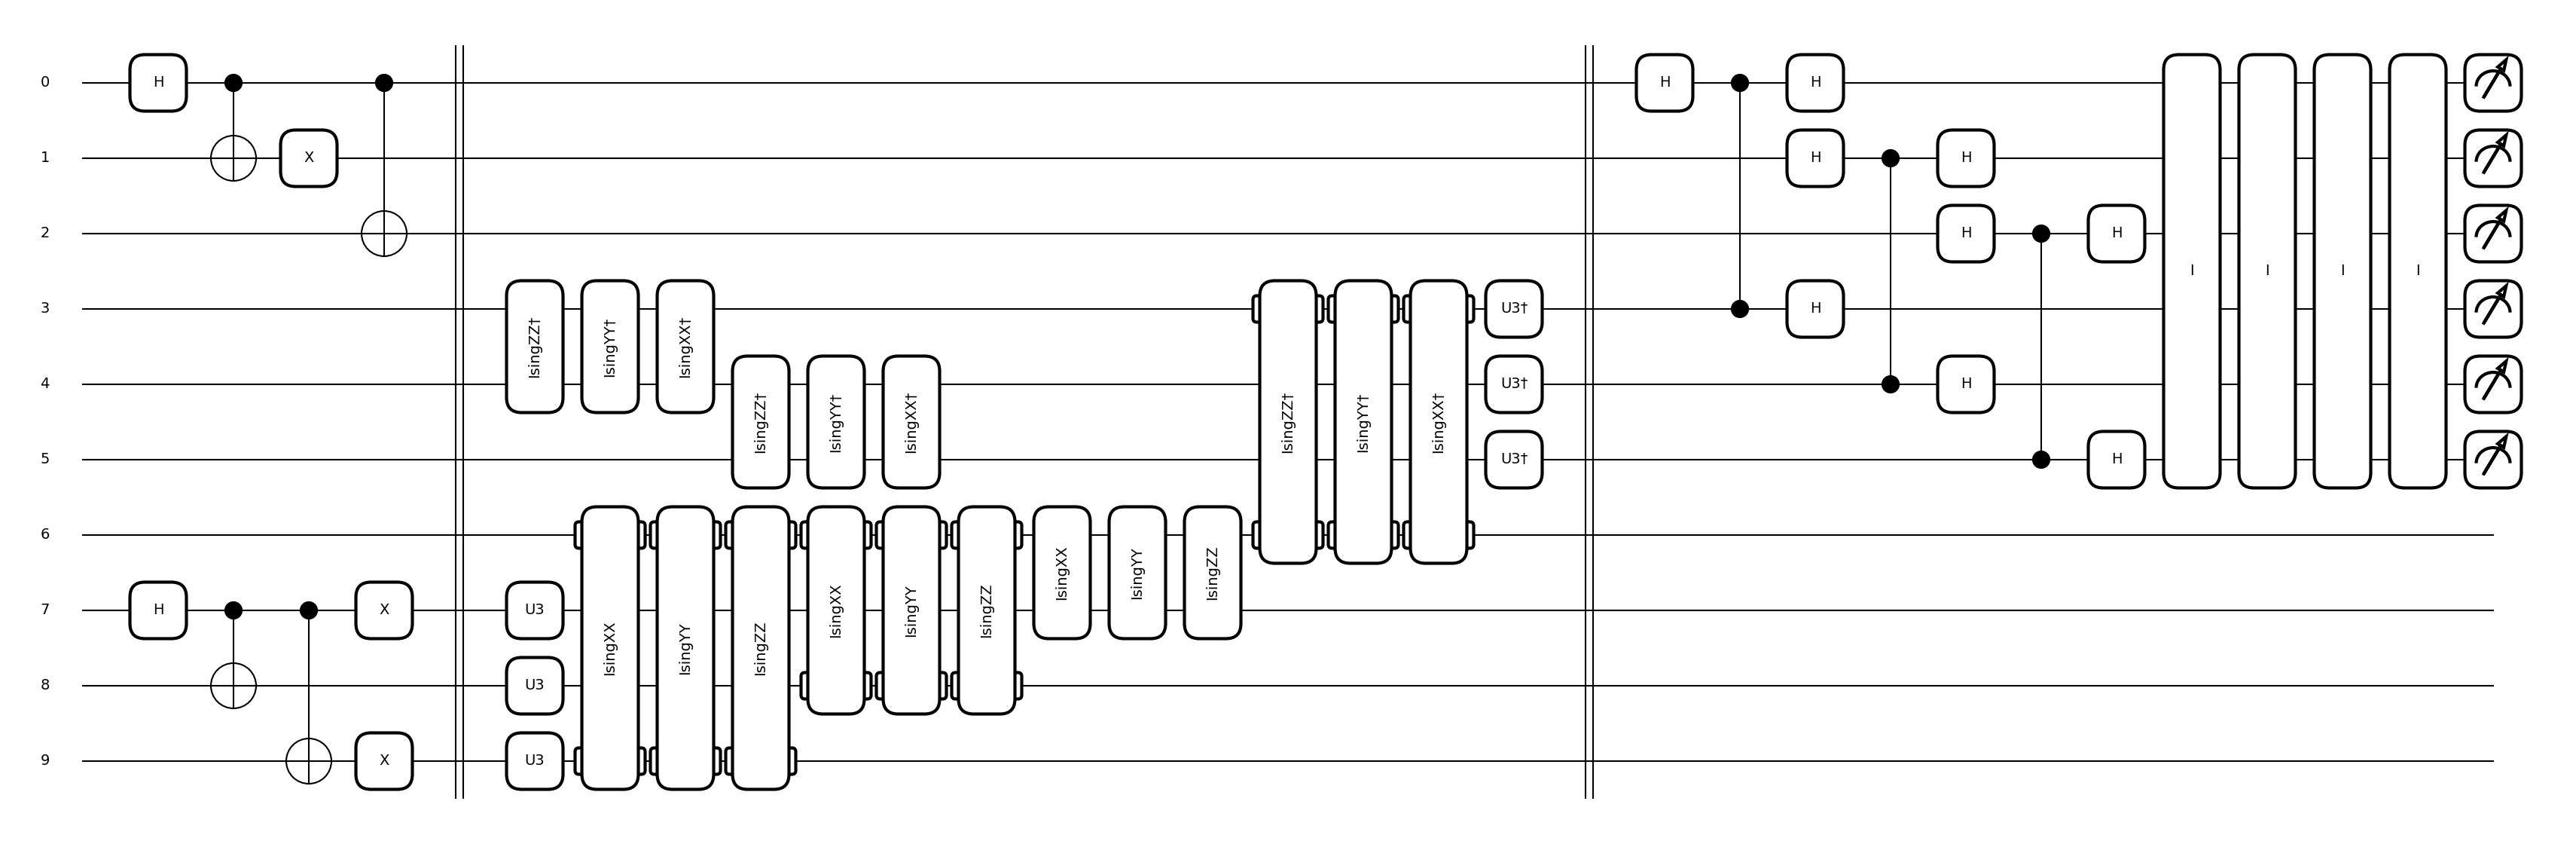

In [19]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
params = np.array([0]*npar)
fig, ax = qml.draw_mpl(circuit)(params)
plt.show()

In [15]:
def Fid_discriminated(params):
    discriminated_output = circuit(params)
    #convert to fidelity
    fid_discriminated_output = 2*discriminated_output-1
    return fid_discriminated_output

In [ ]:
def cost_g(params):
    cost =1-Fid_discriminated(params)
    return cost
def cost_gav(params,batch):
    np.random.seed(0)
    cost_av = []
    for i in range(batch):
        cost_av.append(cost_g(params)) 
        #print(cost_av[i])
    return sum(cost_av)/batch

In [ ]:
def fid_valid(params,batch):
    np.random.seed(0)
    fid = []
    for i in range(batch):
        a = circuit_target()
        b = circuit_valid(params)
        fidelity_evaluation = qml.math.fidelity(a,b)
        fid.append(fidelity_evaluation)
    return sum(fid)/batch
    
def fid_train(params,batch):
    np.random.seed(0)
    fid = []
    for i in range(batch):
        b = circuit_train(params)
        a = circuit_target()
        fidelity_train = qml.math.fidelity(a,b)
        fid.append(fidelity_train)
    return sum(fid)/batch  
    
def Reny_hiddenentropy(params):
    reny1 = np.trace(np.matmul(circuit_Reny(params),circuit_Reny(params)))
    reny = -np.log(reny1)
    return reny

def Reny_finalentropy(params):
    reny1 = np.trace(np.matmul(circuit_train(params),circuit_train(params)))
    reny = -np.log(reny1)
    return reny

def Reny_hiddenentropyb(params,batch):
    re = []
    for i in range(batch):
        reny1 = np.trace(np.matmul(circuit_Reny(params),circuit_Reny(params)))
        reny = -np.log(reny1)
        re.append(reny)
    return sum(re)/batch

def Reny_finalentropyb(params,batch):
    re = []
    for i in range(batch):    
        reny1 = np.trace(np.matmul(circuit_train(params),circuit_train(params)))
        reny = -np.log(reny1)
        re.append(reny)
    return sum(re)/batch

In [ ]:
np.random.seed(0)

#with batch

#init_dqnn_weights = np.random.rand(npar)

init_dqnn_weights1 = np.random.rand(npar)

init_dqnn_weights2 = np.array([ 0.0535576 ,  0.86863388,  0.71216773,  1.50739636,  1.15972834,
        0.62175682,  1.55231045,  1.53159756,  0.95290605,  0.0292384 ,
        1.35690546,  0.04726799,  1.4843123 ,  0.19212465,  0.39984733,
        0.41030086, -1.1148842 ,  1.49957795])

init_dqnn_weights = init_dqnn_weights1+init_dqnn_weights2


dqnn_weights = tf.Variable(init_dqnn_weights,dtype=tf.float64)


loss_val_f = []
trainb =[]
validb = [] 

par = []


batch = 1
epochs = 1
p = 0.2

params = dqnn_weights
for step in range(epochs):
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
        #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
        
        loss = lambda: cost_gav(params,batch)    
        
        opt.minimize(loss, [params])

        loss_val = loss().numpy()
        par.append(params.value())

        loss_val_f.append(loss_val)

        
        #par.append(p)
        
        print("Step {}: loss = {}".format(step, loss_val))



In [ ]:
trainb = []
for i in range(epochs):
    fidelity_train = fid_train(par[i],batch).numpy()
    trainb.append(fidelity_train)
    
validb = []  
for i in range(epochs):
    fidelity_evaluation=fid_valid(par[i],batch).numpy()
    validb.append(fidelity_evaluation)

In [ ]:
renm = []
for i in range(epochs):
    hid = Reny_hiddenentropy(par[i])
    renm.append(hid)
    
renf = []  
for i in range(epochs):
    fin=Reny_finalentropy(par[i])
    renf.append(fin)

In [ ]:
renmb = []
for i in range(epochs):
    hid = Reny_hiddenentropyb(par[i],batch)
    renmb.append(hid)
    
renfb = []  
for i in range(epochs):
    fin=Reny_finalentropyb(par[i],batch)
    renfb.append(fin)

In [ ]:
print('Parameter')
print(par)

print('Training data')
print(trainb) 

print('Validation data')
print(validb)

print('Hidden layer entropy')
print(renm)

print('Final layer entropy')
print(renf)

print('epochs')
print(epochs)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), trainb, label="training data")
plt.plot(range(epochs), validb, label="validation data",color='red', marker='o', linestyle='dotted')
plt.title("({}-{}-{})Modified decoder 3 DQNN p={}".format(m,h,m,p))
plt.xlabel("Iteration",fontsize='14')
plt.ylabel("Fidelity",fontsize='14')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), renmb, label="Renyi-entropy-hidden layer")
plt.plot(range(epochs), renfb, label="Renyi-entropy-output layer",color='red', marker='*', linestyle='solid')
plt.title("({}-{}-{}) Modified decoder 3 DQNN p={}".format(m,h,m,p))
plt.xlabel("Iteration",fontsize='14')
plt.ylabel("Renyi entropy",fontsize='14')
plt.legend()
plt.show()